# [Trend](https://www.kaggle.com/code/ryanholbrook/trend/tutorial)

Any persistent and slow-moving and long-term change in a series could constitute a `trend`.

## Moving Average Plots

From moving average plot, we might find trends in a time series.

![moving_average_plot](image/trend.gif)

## Engineering Trend

* Linear trend (a line)
  e.g. using time dummy: `target = a * time + b`
* Quadratic trend (a parabola)
  e.g. using time dummy feature: `target = a * time^2 + b * time + c`
  

## Example - Tunnel Traffic
### Moving Average Plot

In [1]:
from pathlib import Path
# from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
# %config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("data/tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

Since this series has daily observations, we choose a window of 365 days to smooth over any short-term changes within the year.

To create a moving average, 
1. Use `rolling()` method to begin a windowed computation. 
2. Use `mean()` method to compute the average over the window.

As we can see, the trend of Tunnel Traffic appears to be about linear.

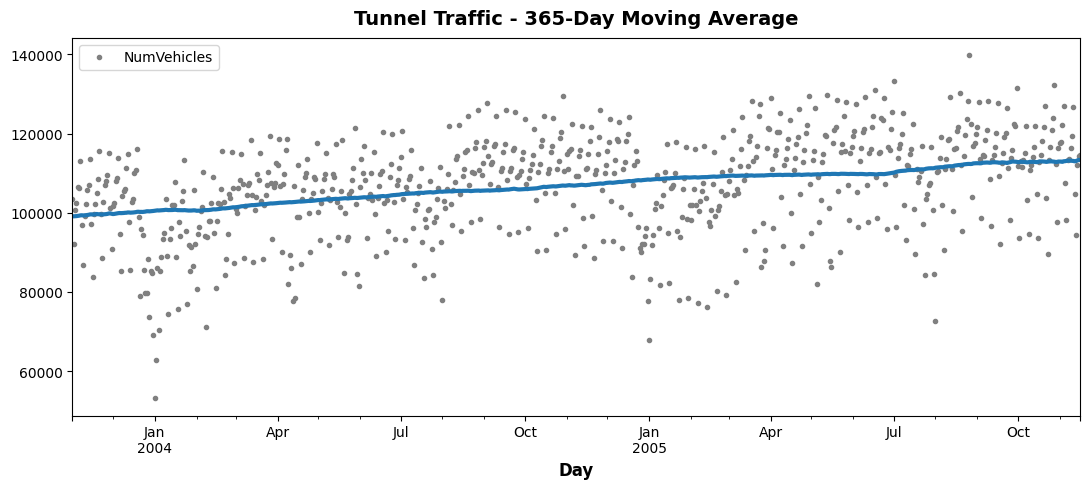

In [2]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

Instead of create time dummy by ourself, we can use [DeterministicProcess](https://www.statsmodels.org/devel/generated/statsmodels.tsa.deterministic.DeterministicProcess.html) to avoid some tricky failure cases. 

The order argument refers to polynomial order: 
* 1: linear
* 2: quadratic
* 3: cubic, and so on.

In [11]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


> *`Deterministic process`* is a process in which the outcome is entirely determined by the initial conditions and the rules or laws governing the system. In other words, given the same initial conditions, a deterministic process will always produce the same outcome or result.

> Features derived from the `time index` will generally be `deterministic`.

### Linear regression model

The intercept is the same as the `const` feature from DeterministicProcess.
LinearRegression behaves badly with duplicated features.
We can exclude it with `fit_intercept=False` argument.

In [4]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# Training model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# make predictions
y_pred = pd.Series(model.predict(X), index=X.index)


Show data in `y_pred` and `y` for comparsion:

In [5]:
print("y_pred:")
display(y_pred.sort_index().head())

print("\ny:")
display(y.sort_index().head())

y_pred:


Day
2003-11-01    98176.206344
2003-11-02    98198.703794
2003-11-03    98221.201243
2003-11-04    98243.698693
2003-11-05    98266.196142
Freq: D, dtype: float64


y:


Day
2003-11-01    103536
2003-11-02     92051
2003-11-03    100795
2003-11-04    102352
2003-11-05    106569
Freq: D, Name: NumVehicles, dtype: int64

Compare y_pred and y, we can see: 
* `y_pred` is predictions of trend (the moving average line).
* `y` is the actual target that used for train moving average.

### Plot the trend predict

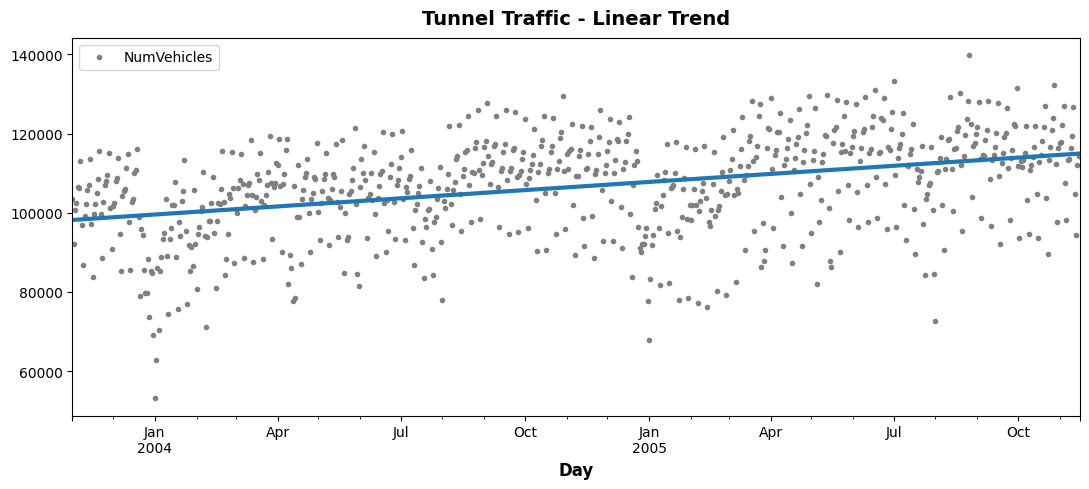

In [6]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

The trend (blue line) discovered by the LinearRegression model is almost identical to the moving average plot.
It suggests that a linear trend was the right decision in this case.

### Forecast

To make a forcase, we use method [DeterministicProcess.out_of_sample(steps, forecast_index=None)](https://www.statsmodels.org/devel/generated/statsmodels.tsa.deterministic.DeterministicProcess.out_of_sample.html) to make a 30-days forcast:

In [10]:
# dp is DeterministicProcess we created previously
# steps: int - number of steps to forecast
X = dp.out_of_sample(steps=30)

# A forecast also producted with predict(X) method.
y_fore = pd.Series(model.predict(X), index=X.index)

print("y_fore:")
display(y_fore.sort_index().head())

print("\ny:")
display(y.sort_index().tail())

y_fore:


2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64


y:


Day
2005-11-12    104646
2005-11-13     94424
2005-11-14    112165
2005-11-15    114296
2005-11-16    114690
Freq: D, Name: NumVehicles, dtype: int64

As we can see the `out_of_sample()` returns the next steps values after the end of the in-sample().

### Plot the trend forcast
Let's plot the trend forcast for the next 30 days

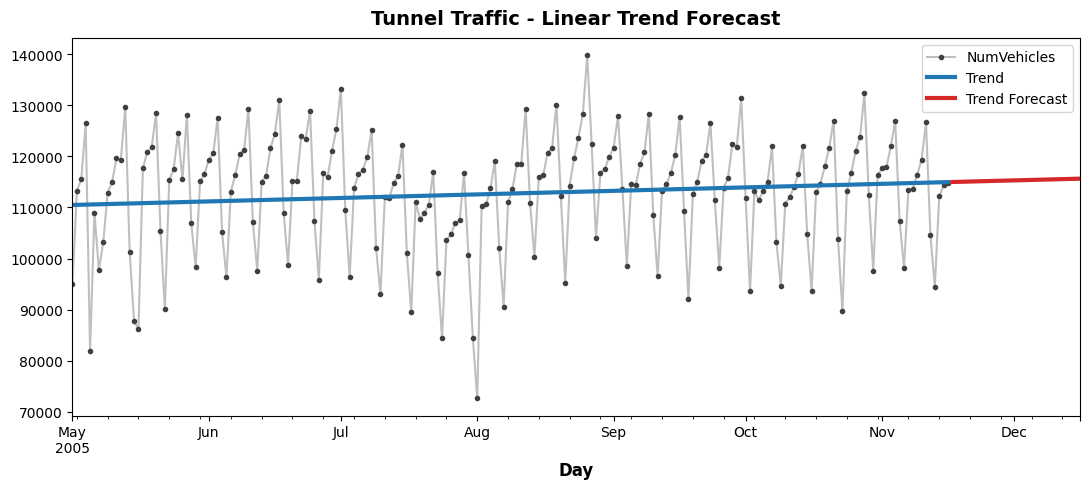

In [12]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)

# plot trend predict: predicated by in_sample() data
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")

# plot trend forcastP predicated by out_of_sample() data
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")

_ = ax.legend()

#### Predict vs Forecast
* Predict: a general term for making predictions in ML
* Forecast: a specific term used in the context of time series analysis to predict future values of a sequence of data points.